# Brain Tumour Segmentation Network
## Import packages
Please make sure you have all the required packages installed for this project.

In [1]:
# Âü∫Á°ÄÂ∫ìÂØºÂÖ•
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Ê∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# ÂõæÂÉèÂ§ÑÁêÜ
from PIL import Image
import nibabel as nib
from scipy.ndimage import zoom

# ËØÑ‰º∞ÊåáÊ†á
from sklearn.metrics import accuracy_score

# ËÆæÁΩÆËÆæÂ§á
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê‰øùËØÅÁªìÊûúÂèØÈáçÂ§ç
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("ÊâÄÊúâÂåÖÂØºÂÖ•ÊàêÂäüÔºÅ")

Using device: cpu
ÊâÄÊúâÂåÖÂØºÂÖ•ÊàêÂäüÔºÅ


## Visualise MRI Volume Slices and Segmentation Maps
Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which are like pixels in 2D images. Here, try to visualise the axial plane (which usually has higher resolution) of some of the volumes and the corresponding segmentation maps.

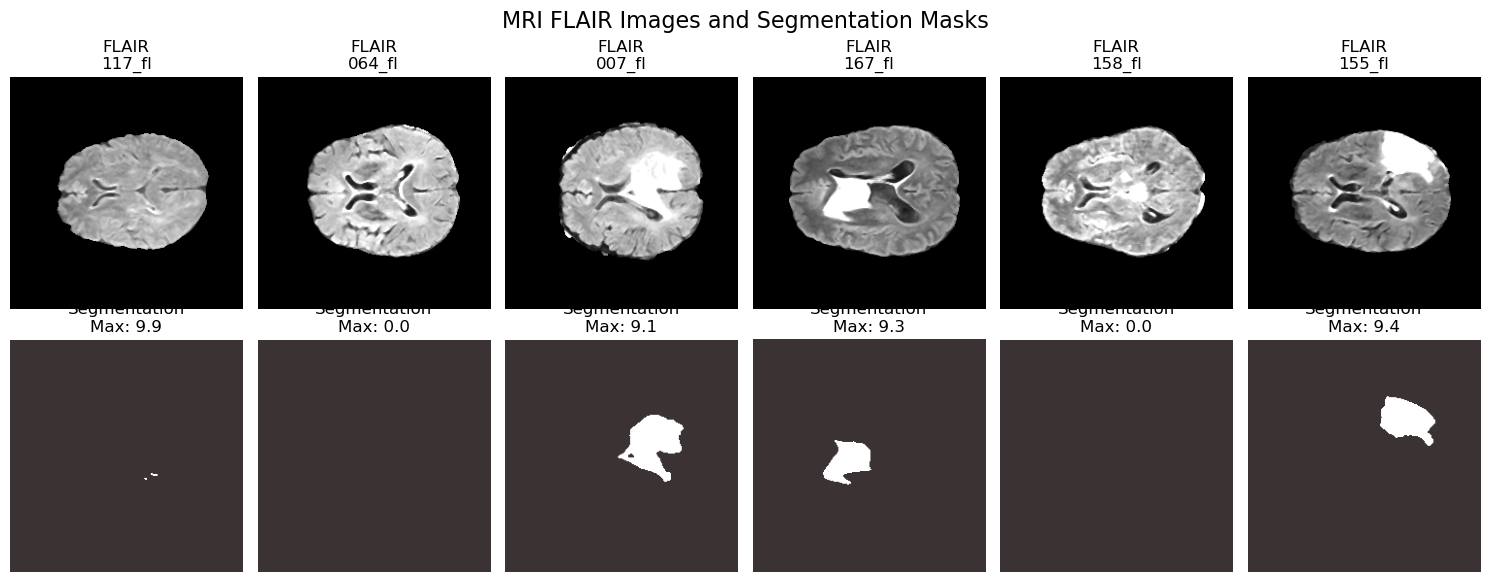


Êï∞ÊçÆÊ¶ÇËßà:
ÊâæÂà∞ 210 ‰∏™FLAIRÊñá‰ª∂
ÂõæÂÉèÂ∞∫ÂØ∏: (240, 240, 155)
Êï∞ÊçÆËåÉÂõ¥: -0.448 Âà∞ 3.265


In [2]:
# ËÆæÁΩÆÊï∞ÊçÆË∑ØÂæÑ
DATA_PATH = "/Users/dd/Desktop/DSI Summer School Project tutorial CV/dataset_segmentation/train"

def visualize_mri_and_segmentation(data_path, num_samples=6):
    """
    ÂèØËßÜÂåñMRIÂàáÁâáÂíåÂØπÂ∫îÁöÑÂàÜÂâ≤ËíôÁâà
    """
    # Ëé∑ÂèñÊâÄÊúâÁöÑFLAIRÊñá‰ª∂
    flair_files = glob.glob(os.path.join(data_path, "*_fla_proc.npy"))
    
    # ÈöèÊú∫ÈÄâÊã©Âá†‰∏™Êñá‰ª∂
    selected_files = random.sample(flair_files, min(num_samples, len(flair_files)))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('MRI FLAIR Images and Segmentation Masks', fontsize=16)
    
    for i, flair_path in enumerate(selected_files):
        # Âä†ËΩΩFLAIRÂõæÂÉè
        flair_data = np.load(flair_path)
        
        # ÊûÑÈÄ†ÂØπÂ∫îÁöÑÂàÜÂâ≤Êñá‰ª∂Ë∑ØÂæÑ
        seg_path = flair_path.replace("_fla_proc.npy", "_seg_proc.npy")
        
        if os.path.exists(seg_path):
            seg_data = np.load(seg_path)
            
            # ÈÄâÊã©‰∏≠Èó¥ÂàáÁâá
            slice_idx = flair_data.shape[2] // 2
            flair_slice = flair_data[:, :, slice_idx]
            seg_slice = seg_data[:, :, slice_idx]
            
            # ÊòæÁ§∫FLAIRÂõæÂÉè
            axes[0, i].imshow(flair_slice, cmap='gray')
            axes[0, i].set_title(f'FLAIR\n{os.path.basename(flair_path)[:6]}')
            axes[0, i].axis('off')
            
            # ÊòæÁ§∫ÂàÜÂâ≤ËíôÁâà
            axes[1, i].imshow(seg_slice, cmap='hot', alpha=0.8)
            axes[1, i].set_title(f'Segmentation\nMax: {seg_slice.max():.1f}')
            axes[1, i].axis('off')
        else:
            print(f"ÂàÜÂâ≤Êñá‰ª∂‰∏çÂ≠òÂú®: {seg_path}")
    
    plt.tight_layout()
    plt.show()
    
    # ÊâìÂç∞Êï∞ÊçÆ‰ø°ÊÅØ
    print(f"\nÊï∞ÊçÆÊ¶ÇËßà:")
    print(f"ÊâæÂà∞ {len(flair_files)} ‰∏™FLAIRÊñá‰ª∂")
    if flair_files:
        sample_data = np.load(flair_files[0])
        print(f"ÂõæÂÉèÂ∞∫ÂØ∏: {sample_data.shape}")
        print(f"Êï∞ÊçÆËåÉÂõ¥: {sample_data.min():.3f} Âà∞ {sample_data.max():.3f}")

# ËøêË°åÂèØËßÜÂåñ
visualize_mri_and_segmentation(DATA_PATH, num_samples=6)

## Data preprocessing (Optional)

Images in the original dataset are usually of different sizes, so sometimes we need to resize and normalise them (z-score is commonly used in preprocessing MRI images) to fit the CNN model. Depending on the images you choose to use for training your model, you may need to apply other preprocessing methods. If preprocessing methods like cropping are applied, remember to convert the segmentation result back to its original size.

ÂàõÂª∫È¢ÑÂ§ÑÁêÜÁöÑËÆ≠ÁªÉÊï∞ÊçÆ...
Â§ÑÁêÜ 50 ‰∏™Êñá‰ª∂...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:02<00:00, 16.93it/s]


Â§ÑÁêÜÂÆåÊàê!
ÂõæÂÉèÊï∞ÊçÆÂΩ¢Áä∂: (50, 256, 256)
ËíôÁâàÊï∞ÊçÆÂΩ¢Áä∂: (50, 256, 256)
ÂõæÂÉèÊï∞ÊçÆËåÉÂõ¥: -0.685 Âà∞ 3.375
ËíôÁâà‰∏≠ÊúâËÇøÁò§ÁöÑÊ†∑Êú¨: 28 / 50


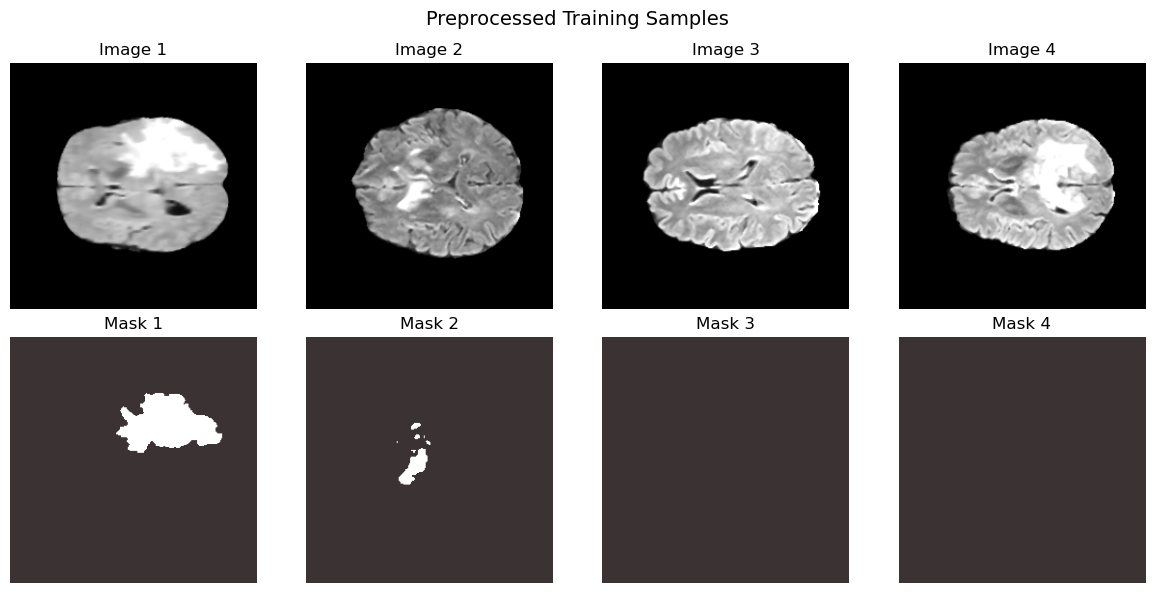

In [3]:
# Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÂáΩÊï∞
def preprocess_data(image, mask, target_size=(256, 256)):
    """
    ÂØπÂõæÂÉèÂíåËíôÁâàËøõË°åÈ¢ÑÂ§ÑÁêÜ
    
    Args:
        image: FLAIRÂõæÂÉè (H, W, D)
        mask: ÂàÜÂâ≤ËíôÁâà (H, W, D)
        target_size: ÁõÆÊ†áÂ∞∫ÂØ∏ (H, W)
    
    Returns:
        processed_image: È¢ÑÂ§ÑÁêÜÂêéÁöÑÂõæÂÉè
        processed_mask: È¢ÑÂ§ÑÁêÜÂêéÁöÑËíôÁâà
    """
    # ÈÄâÊã©‰∏≠Èó¥ÂàáÁâá
    slice_idx = image.shape[2] // 2
    img_slice = image[:, :, slice_idx]
    mask_slice = mask[:, :, slice_idx]
    
    # ÂõæÂÉèÊ†áÂáÜÂåñ (Z-score normalization)
    mean = np.mean(img_slice)
    std = np.std(img_slice)
    img_slice = (img_slice - mean) / (std + 1e-8)
    
    # Ë∞ÉÊï¥ÂõæÂÉèÂ∞∫ÂØ∏
    from scipy.ndimage import zoom
    
    # ËÆ°ÁÆóÁº©ÊîæÂõ†Â≠ê
    scale_h = target_size[0] / img_slice.shape[0]
    scale_w = target_size[1] / img_slice.shape[1]
    
    # Áº©ÊîæÂõæÂÉèÂíåËíôÁâà
    img_resized = zoom(img_slice, (scale_h, scale_w), order=1)  # ÂèåÁ∫øÊÄßÊèíÂÄº
    mask_resized = zoom(mask_slice, (scale_h, scale_w), order=0)  # ÊúÄËøëÈÇªÊèíÂÄº
    
    # Â∞ÜËíôÁâà‰∫åÂÄºÂåñ
    mask_resized = (mask_resized > 0.5).astype(np.float32)
    
    return img_resized, mask_resized

def create_training_data(data_path, target_size=(256, 256), max_samples=None):
    """
    ÂàõÂª∫ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ
    """
    flair_files = glob.glob(os.path.join(data_path, "*_fla_proc.npy"))
    
    if max_samples:
        flair_files = flair_files[:max_samples]
    
    images = []
    masks = []
    
    print(f"Â§ÑÁêÜ {len(flair_files)} ‰∏™Êñá‰ª∂...")
    
    for i, flair_path in enumerate(tqdm(flair_files)):
        # Âä†ËΩΩÊï∞ÊçÆ
        flair_data = np.load(flair_path)
        seg_path = flair_path.replace("_fla_proc.npy", "_seg_proc.npy")
        
        if os.path.exists(seg_path):
            seg_data = np.load(seg_path)
            
            # È¢ÑÂ§ÑÁêÜ
            img_processed, mask_processed = preprocess_data(
                flair_data, seg_data, target_size
            )
            
            images.append(img_processed)
            masks.append(mask_processed)
    
    images = np.array(images)
    masks = np.array(masks)
    
    print(f"Â§ÑÁêÜÂÆåÊàê!")
    print(f"ÂõæÂÉèÊï∞ÊçÆÂΩ¢Áä∂: {images.shape}")
    print(f"ËíôÁâàÊï∞ÊçÆÂΩ¢Áä∂: {masks.shape}")
    print(f"ÂõæÂÉèÊï∞ÊçÆËåÉÂõ¥: {images.min():.3f} Âà∞ {images.max():.3f}")
    print(f"ËíôÁâà‰∏≠ÊúâËÇøÁò§ÁöÑÊ†∑Êú¨: {np.sum(masks.sum(axis=(1,2)) > 0)} / {len(masks)}")
    
    return images, masks

# ÂàõÂª∫ËÆ≠ÁªÉÊï∞ÊçÆ (ÂÖàÂ§ÑÁêÜÂ∞ëÈáèÊ†∑Êú¨ÊµãËØï)
print("ÂàõÂª∫È¢ÑÂ§ÑÁêÜÁöÑËÆ≠ÁªÉÊï∞ÊçÆ...")
train_images, train_masks = create_training_data(DATA_PATH, target_size=(256, 256), max_samples=50)

# ÂèØËßÜÂåñÈ¢ÑÂ§ÑÁêÜÁªìÊûú
def show_preprocessed_samples(images, masks, num_samples=4):
    """ÊòæÁ§∫È¢ÑÂ§ÑÁêÜÂêéÁöÑÊ†∑Êú¨"""
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    fig.suptitle('Preprocessed Training Samples', fontsize=14)
    
    for i in range(num_samples):
        # ÊòæÁ§∫ÂõæÂÉè
        axes[0, i].imshow(images[i], cmap='gray')
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')
        
        # ÊòæÁ§∫ËíôÁâà
        axes[1, i].imshow(masks[i], cmap='hot', alpha=0.8)
        axes[1, i].set_title(f'Mask {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# ÊòæÁ§∫È¢ÑÂ§ÑÁêÜÁªìÊûú
show_preprocessed_samples(train_images, train_masks, num_samples=4)

## Train-time data augmentation
Generalizability is crucial to a deep learning model, and it refers to the performance difference of a model when evaluated on seen data (training data) versus unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

**Data Augmentation** is an effective way of improving generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimize the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose from in this project, including rotation, shifting, flipping, etc. PyTorch provides excellent data augmentation capabilities through torchvision.transforms, which you can combine with custom transforms for medical imaging.

You are encouraged to try different augmentation methods to get the best segmentation result.


## Get the data generator ready

ÂàõÂª∫ËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜ...
ËÆ≠ÁªÉÈõÜ: 40 Ê†∑Êú¨
È™åËØÅÈõÜ: 10 Ê†∑Êú¨
ËÆ≠ÁªÉÊâπÊ¨°Êï∞: 5
È™åËØÅÊâπÊ¨°Êï∞: 2

ÊµãËØïÊï∞ÊçÆÂä†ËΩΩÂô®...
ÊâπÊ¨°ÂõæÂÉèÂΩ¢Áä∂: torch.Size([8, 1, 256, 256])
ÊâπÊ¨°ËíôÁâàÂΩ¢Áä∂: torch.Size([8, 256, 256])
ÂõæÂÉèÊï∞ÊçÆÁ±ªÂûã: torch.float32
ËíôÁâàÊï∞ÊçÆÁ±ªÂûã: torch.int64
ÂõæÂÉèÂÄºËåÉÂõ¥: -0.864 Âà∞ 3.036
ËíôÁâàÂÄºËåÉÂõ¥: 0 Âà∞ 1


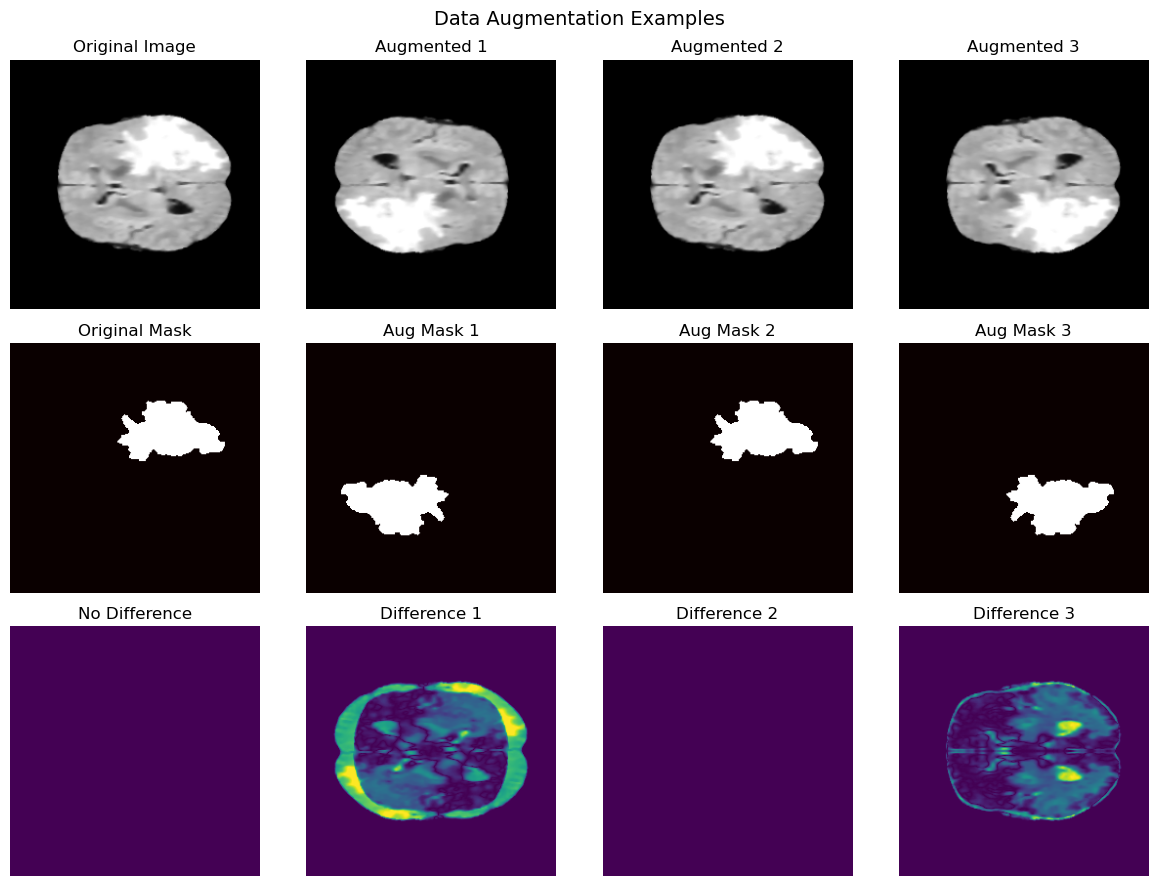

In [4]:
# Êï∞ÊçÆÂ¢ûÂº∫ÂáΩÊï∞
def augment_data(image, mask):
    """
    ÂØπÂõæÂÉèÂíåËíôÁâàËøõË°åÊï∞ÊçÆÂ¢ûÂº∫
    """
    # ÈöèÊú∫Ê∞¥Âπ≥ÁøªËΩ¨
    if random.random() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    
    # ÈöèÊú∫ÂûÇÁõ¥ÁøªËΩ¨
    if random.random() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    
    # ÈöèÊú∫ÊóãËΩ¨ÔºàÂ∞èËßíÂ∫¶Ôºâ
    if random.random() > 0.5:
        angle = random.uniform(-10, 10)  # -10Âà∞10Â∫¶
        from scipy.ndimage import rotate
        image = rotate(image, angle, reshape=False, order=1, mode='constant', cval=0)
        mask = rotate(mask, angle, reshape=False, order=0, mode='constant', cval=0)
    
    # Ê∑ªÂä†ÈöèÊú∫Âô™Â£∞
    if random.random() > 0.7:
        noise = np.random.normal(0, 0.05, image.shape)
        image = image + noise
    
    return image, mask

# Ëá™ÂÆö‰πâDatasetÁ±ª
class BrainSegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask = self.masks[idx].copy()
        
        # Êï∞ÊçÆÂ¢ûÂº∫
        if self.augment:
            image, mask = augment_data(image, mask)
        
        # ËΩ¨Êç¢‰∏∫PyTorchÂº†Èáè
        # ÂõæÂÉè: (1, H, W) - ÂçïÈÄöÈÅì
        # ËíôÁâà: (H, W) - Ê†áÁ≠æ
        image = torch.FloatTensor(image).unsqueeze(0)  # Ê∑ªÂä†ÈÄöÈÅìÁª¥Â∫¶
        mask = torch.LongTensor(mask.astype(np.int64))
        
        return image, mask

# ÂàÜÂâ≤ËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜ
def split_train_val(images, masks, val_split=0.2):
    """ÂàÜÂâ≤Êï∞ÊçÆ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜ"""
    n_samples = len(images)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - val_split))
    
    train_idx = indices[:split_idx]
    val_idx = indices[split_idx:]
    
    train_images = images[train_idx]
    train_masks = masks[train_idx]
    val_images = images[val_idx]
    val_masks = masks[val_idx]
    
    return train_images, train_masks, val_images, val_masks

# ÂàõÂª∫Êï∞ÊçÆÈõÜ
print("ÂàõÂª∫ËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜ...")
train_imgs, train_msks, val_imgs, val_msks = split_train_val(train_images, train_masks, val_split=0.2)

print(f"ËÆ≠ÁªÉÈõÜ: {len(train_imgs)} Ê†∑Êú¨")
print(f"È™åËØÅÈõÜ: {len(val_imgs)} Ê†∑Êú¨")

# ÂàõÂª∫DatasetÂíåDataLoader
batch_size = 8

train_dataset = BrainSegmentationDataset(train_imgs, train_msks, augment=True)
val_dataset = BrainSegmentationDataset(val_imgs, val_msks, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"ËÆ≠ÁªÉÊâπÊ¨°Êï∞: {len(train_loader)}")
print(f"È™åËØÅÊâπÊ¨°Êï∞: {len(val_loader)}")

# ÊµãËØïÊï∞ÊçÆÂä†ËΩΩÂô®
def test_dataloader():
    """ÊµãËØïÊï∞ÊçÆÂä†ËΩΩÂô®"""
    print("\nÊµãËØïÊï∞ÊçÆÂä†ËΩΩÂô®...")
    
    # Ëé∑Âèñ‰∏Ä‰∏™ÊâπÊ¨°
    for images, masks in train_loader:
        print(f"ÊâπÊ¨°ÂõæÂÉèÂΩ¢Áä∂: {images.shape}")  # Â∫îËØ•ÊòØ [batch_size, 1, 256, 256]
        print(f"ÊâπÊ¨°ËíôÁâàÂΩ¢Áä∂: {masks.shape}")    # Â∫îËØ•ÊòØ [batch_size, 256, 256]
        print(f"ÂõæÂÉèÊï∞ÊçÆÁ±ªÂûã: {images.dtype}")
        print(f"ËíôÁâàÊï∞ÊçÆÁ±ªÂûã: {masks.dtype}")
        print(f"ÂõæÂÉèÂÄºËåÉÂõ¥: {images.min():.3f} Âà∞ {images.max():.3f}")
        print(f"ËíôÁâàÂÄºËåÉÂõ¥: {masks.min()} Âà∞ {masks.max()}")
        break

test_dataloader()

# ÂèØËßÜÂåñÂ¢ûÂº∫ÂêéÁöÑÊ†∑Êú¨
def show_augmented_samples():
    """ÊòæÁ§∫Êï∞ÊçÆÂ¢ûÂº∫ÊïàÊûú"""
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle('Data Augmentation Examples', fontsize=14)
    
    # Ëé∑Âèñ‰∏Ä‰∏™ÂéüÂßãÊ†∑Êú¨
    original_img = train_images[0]
    original_mask = train_masks[0]
    
    # ÊòæÁ§∫ÂéüÂßãÂõæÂÉè
    axes[0, 0].imshow(original_img, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(original_mask, cmap='hot')
    axes[1, 0].set_title('Original Mask')
    axes[1, 0].axis('off')
    
    # ÁîüÊàê3‰∏™Â¢ûÂº∫ÁâàÊú¨
    for i in range(3):
        aug_img, aug_mask = augment_data(original_img.copy(), original_mask.copy())
        
        axes[0, i+1].imshow(aug_img, cmap='gray')
        axes[0, i+1].set_title(f'Augmented {i+1}')
        axes[0, i+1].axis('off')
        
        axes[1, i+1].imshow(aug_mask, cmap='hot')
        axes[1, i+1].set_title(f'Aug Mask {i+1}')
        axes[1, i+1].axis('off')
        
        # ÊòæÁ§∫Â∑ÆÂºÇ
        diff = np.abs(original_img - aug_img)
        axes[2, i+1].imshow(diff, cmap='viridis')
        axes[2, i+1].set_title(f'Difference {i+1}')
        axes[2, i+1].axis('off')
    
    # ÂéüÂßãÂ∑ÆÂºÇ‰∏∫0
    axes[2, 0].imshow(np.zeros_like(original_img), cmap='viridis')
    axes[2, 0].set_title('No Difference')
    axes[2, 0].axis('off')
    
    plt.tight_layout()
    plt.show()

show_augmented_samples()

## Define a metric for the performance of the model
The Dice score is used here to evaluate the performance of your model.
More details about the Dice score and other metrics can be found at 
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. The Dice score can also be used as the loss function for training your model.

ÊµãËØïËØÑ‰º∞ÊåáÊ†á...
È¢ÑÊµãlogitsÂΩ¢Áä∂: torch.Size([4, 2, 256, 256])
È¢ÑÊµãÊ¶ÇÁéáÂΩ¢Áä∂: torch.Size([4, 2, 256, 256])
È¢ÑÊµãÁ±ªÂà´ÂΩ¢Áä∂: torch.Size([4, 256, 256])
ÁúüÂÆûÊ†áÁ≠æÂΩ¢Áä∂: torch.Size([4, 256, 256])

DiceÁ≥ªÊï∞: 0.5008
DiceÊçüÂ§±: 0.4992
IoUÁ≥ªÊï∞: 0.3341

ÂÆåÁæéÈ¢ÑÊµã:
DiceÁ≥ªÊï∞: 1.0000
IoUÁ≥ªÊï∞: 1.0000


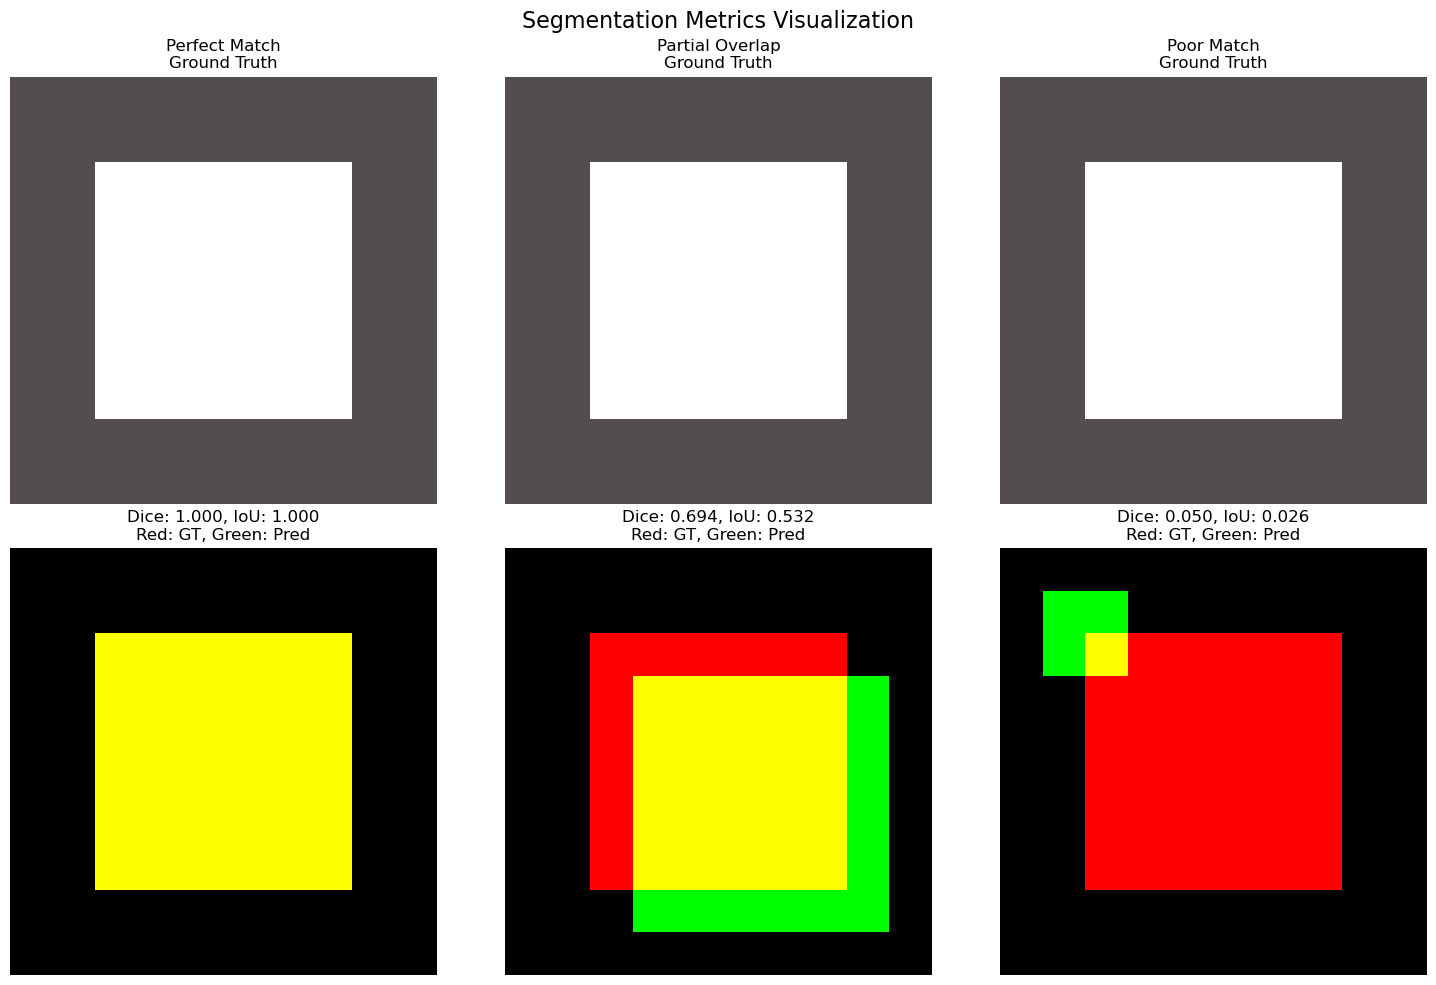

In [5]:
# DiceÁ≥ªÊï∞Áõ∏ÂÖ≥ÂáΩÊï∞
def dice_coefficient(pred, target, smooth=1e-6):
    """
    ËÆ°ÁÆóDiceÁ≥ªÊï∞
    
    Args:
        pred: È¢ÑÊµãÁªìÊûú (N, H, W) Êàñ (N, C, H, W)
        target: ÁúüÂÆûÊ†áÁ≠æ (N, H, W)
        smooth: Âπ≥ÊªëÂõ†Â≠êÔºåÈÅøÂÖçÈô§Èõ∂
    
    Returns:
        dice: DiceÁ≥ªÊï∞ (0-1ÔºåË∂äÈ´òË∂äÂ•Ω)
    """
    # Â¶ÇÊûúÈ¢ÑÊµãÊúâÂ§ö‰∏™ÈÄöÈÅìÔºåÂèñÊ¶ÇÁéáÊúÄÂ§ßÁöÑÁ±ªÂà´
    if len(pred.shape) == 4:
        pred = torch.argmax(pred, dim=1)
    
    # ËΩ¨Êç¢‰∏∫floatÁ±ªÂûã
    pred = pred.float()
    target = target.float()
    
    # ËÆ°ÁÆó‰∫§ÈõÜÂíåÂπ∂ÈõÜ
    intersection = (pred * target).sum(dim=(1, 2))
    union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2))
    
    # ËÆ°ÁÆóDiceÁ≥ªÊï∞
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    return dice.mean()

def dice_loss(pred, target, smooth=1e-6):
    """
    DiceÊçüÂ§±ÂáΩÊï∞ (1 - DiceÁ≥ªÊï∞)
    Áî®‰ΩúËÆ≠ÁªÉÊó∂ÁöÑÊçüÂ§±ÂáΩÊï∞
    """
    return 1 - dice_coefficient(pred, target, smooth)

def iou_coefficient(pred, target, smooth=1e-6):
    """
    ËÆ°ÁÆóIoU (Intersection over Union) Á≥ªÊï∞
    ‰πüÁß∞‰∏∫JaccardÊåáÊï∞
    """
    # Â¶ÇÊûúÈ¢ÑÊµãÊúâÂ§ö‰∏™ÈÄöÈÅìÔºåÂèñÊ¶ÇÁéáÊúÄÂ§ßÁöÑÁ±ªÂà´
    if len(pred.shape) == 4:
        pred = torch.argmax(pred, dim=1)
    
    # ËΩ¨Êç¢‰∏∫floatÁ±ªÂûã
    pred = pred.float()
    target = target.float()
    
    # ËÆ°ÁÆó‰∫§ÈõÜÂíåÂπ∂ÈõÜ
    intersection = (pred * target).sum(dim=(1, 2))
    union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2)) - intersection
    
    # ËÆ°ÁÆóIoU
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.mean()

# ÊµãËØïËØÑ‰º∞ÊåáÊ†á
def test_metrics():
    """ÊµãËØïËØÑ‰º∞ÊåáÊ†áÂáΩÊï∞"""
    print("ÊµãËØïËØÑ‰º∞ÊåáÊ†á...")
    
    # ÂàõÂª∫ÊµãËØïÊï∞ÊçÆ
    batch_size = 4
    height, width = 256, 256
    
    # Ê®°ÊãüÈ¢ÑÊµãÁªìÊûú (batch_size, num_classes, height, width)
    pred_logits = torch.randn(batch_size, 2, height, width)  # 2Á±ªÔºöËÉåÊôØÂíåËÇøÁò§
    pred_probs = torch.softmax(pred_logits, dim=1)  # ËΩ¨Êç¢‰∏∫Ê¶ÇÁéá
    pred_binary = torch.argmax(pred_probs, dim=1)   # ËΩ¨Êç¢‰∏∫Á±ªÂà´
    
    # ÂàõÂª∫ÈöèÊú∫ÁöÑÁúüÂÆûÊ†áÁ≠æ
    target = torch.randint(0, 2, (batch_size, height, width))
    
    print(f"È¢ÑÊµãlogitsÂΩ¢Áä∂: {pred_logits.shape}")
    print(f"È¢ÑÊµãÊ¶ÇÁéáÂΩ¢Áä∂: {pred_probs.shape}")
    print(f"È¢ÑÊµãÁ±ªÂà´ÂΩ¢Áä∂: {pred_binary.shape}")
    print(f"ÁúüÂÆûÊ†áÁ≠æÂΩ¢Áä∂: {target.shape}")
    
    # ËÆ°ÁÆóÊåáÊ†á
    dice_score = dice_coefficient(pred_logits, target)
    dice_loss_value = dice_loss(pred_logits, target)
    iou_score = iou_coefficient(pred_logits, target)
    
    print(f"\nDiceÁ≥ªÊï∞: {dice_score:.4f}")
    print(f"DiceÊçüÂ§±: {dice_loss_value:.4f}")
    print(f"IoUÁ≥ªÊï∞: {iou_score:.4f}")
    
    # ÊµãËØïÂÆåÁæéÈ¢ÑÊµã
    perfect_pred = target.unsqueeze(1)  # Ê∑ªÂä†Á±ªÂà´Áª¥Â∫¶
    perfect_logits = torch.zeros(batch_size, 2, height, width)
    for i in range(batch_size):
        for h in range(height):
            for w in range(width):
                if target[i, h, w] == 1:
                    perfect_logits[i, 1, h, w] = 10  # ËÇøÁò§Á±ªÂà´È´òÂàÜ
                    perfect_logits[i, 0, h, w] = -10  # ËÉåÊôØÁ±ªÂà´‰ΩéÂàÜ
                else:
                    perfect_logits[i, 0, h, w] = 10   # ËÉåÊôØÁ±ªÂà´È´òÂàÜ
                    perfect_logits[i, 1, h, w] = -10  # ËÇøÁò§Á±ªÂà´‰ΩéÂàÜ
    
    perfect_dice = dice_coefficient(perfect_logits, target)
    perfect_iou = iou_coefficient(perfect_logits, target)
    
    print(f"\nÂÆåÁæéÈ¢ÑÊµã:")
    print(f"DiceÁ≥ªÊï∞: {perfect_dice:.4f}")
    print(f"IoUÁ≥ªÊï∞: {perfect_iou:.4f}")

test_metrics()

# ÂèØËßÜÂåñËØÑ‰º∞ÊåáÊ†á
def visualize_metrics_example():
    """ÂèØËßÜÂåñËØÑ‰º∞ÊåáÊ†áÁöÑ‰æãÂ≠ê"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Segmentation Metrics Visualization', fontsize=16)
    
    # ÂàõÂª∫Á§∫‰æãÊï∞ÊçÆ
    size = 100
    
    # Á§∫‰æã1: ÂÆåÁæéÈ¢ÑÊµã
    target1 = np.zeros((size, size))
    target1[20:80, 20:80] = 1  # Ê≠£ÊñπÂΩ¢ËÇøÁò§Âå∫Âüü
    pred1 = target1.copy()
    
    # Á§∫‰æã2: ÈÉ®ÂàÜÈáçÂè†
    target2 = target1.copy()
    pred2 = np.zeros((size, size))
    pred2[30:90, 30:90] = 1  # ÂÅèÁßªÁöÑÊ≠£ÊñπÂΩ¢
    
    # Á§∫‰æã3: ËæÉÂ∑ÆÈ¢ÑÊµã
    target3 = target1.copy()
    pred3 = np.zeros((size, size))
    pred3[10:30, 10:30] = 1  # Â∞èÁöÑÈ¢ÑÊµãÂå∫Âüü
    
    examples = [
        (target1, pred1, "Perfect Match"),
        (target2, pred2, "Partial Overlap"), 
        (target3, pred3, "Poor Match")
    ]
    
    for i, (target, pred, title) in enumerate(examples):
        # ËÆ°ÁÆóÊåáÊ†á
        target_t = torch.FloatTensor(target).unsqueeze(0)
        pred_t = torch.FloatTensor(pred).unsqueeze(0)
        
        dice = dice_coefficient(pred_t, target_t)
        iou = iou_coefficient(pred_t, target_t)
        
        # ÊòæÁ§∫ÁúüÂÆûÊ†áÁ≠æ
        axes[0, i].imshow(target, cmap='hot', alpha=0.7)
        axes[0, i].set_title(f'{title}\nGround Truth')
        axes[0, i].axis('off')
        
        # ÊòæÁ§∫È¢ÑÊµãÁªìÊûúÂíåÈáçÂè†Âå∫Âüü
        overlay = np.zeros((size, size, 3))
        overlay[:, :, 0] = target  # Á∫¢Ëâ≤: ÁúüÂÆû
        overlay[:, :, 1] = pred    # ÁªøËâ≤: È¢ÑÊµã
        # ÈáçÂè†Âå∫Âüü‰ºöÊòæÁ§∫‰∏∫ÈªÑËâ≤
        
        axes[1, i].imshow(overlay)
        axes[1, i].set_title(f'Dice: {dice:.3f}, IoU: {iou:.3f}\nRed: GT, Green: Pred')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_metrics_example()

## Build your own model here
The U-Net (https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) structure is widely used for medical image segmentation tasks. You can build your own model or modify the U-Net by changing the hyperparameters for our task. If you choose to use PyTorch, more information about PyTorch layers, including Conv2d, MaxPool2d, and Dropout, can be found at https://pytorch.org/docs/stable/nn.html. You can also explore popular PyTorch implementations of U-Net for medical image segmentation.

In [6]:
# U-NetÊ®°ÂûãÁªÑ‰ª∂

# ÂèåÂç∑ÁßØÂùó
class DoubleConv(nn.Module):
    """ÂèåÂç∑ÁßØÂ±ÇÂùó: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU"""
    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

# ‰∏ãÈááÊ†∑Âùó
class Down(nn.Module):
    """‰∏ãÈááÊ†∑: MaxPool -> DoubleConv"""
    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

# ‰∏äÈááÊ†∑Âùó
class Up(nn.Module):
    """‰∏äÈááÊ†∑: TransposeConv -> Concat -> DoubleConv"""
    
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Â§ÑÁêÜÂ∞∫ÂØ∏‰∏çÂåπÈÖçÁöÑÊÉÖÂÜµ
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # ËøûÊé•skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# ËæìÂá∫Â±Ç
class OutConv(nn.Module):
    """ÊúÄÁªàËæìÂá∫Â±Ç: 1x1Âç∑ÁßØ"""
    
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

# ÂÆåÊï¥ÁöÑU-NetÊ®°Âûã
class UNet(nn.Module):
    """
    U-NetÊû∂ÊûÑÁî®‰∫éÂåªÂ≠¶ÂõæÂÉèÂàÜÂâ≤
    
    Args:
        n_channels: ËæìÂÖ•ÈÄöÈÅìÊï∞ (1 for grayscale)
        n_classes: ËæìÂá∫Á±ªÂà´Êï∞ (2 for binary segmentation)
        base_channels: Âü∫Á°ÄÈÄöÈÅìÊï∞ (ÈªòËÆ§64)
    """
    
    def __init__(self, n_channels=1, n_classes=2, base_channels=64):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # ÁºñÁ†ÅÂô® (Êî∂Áº©Ë∑ØÂæÑ)
        self.inc = DoubleConv(n_channels, base_channels)           # 256x256x64
        self.down1 = Down(base_channels, base_channels * 2)        # 128x128x128
        self.down2 = Down(base_channels * 2, base_channels * 4)    # 64x64x256
        self.down3 = Down(base_channels * 4, base_channels * 8)    # 32x32x512
        self.down4 = Down(base_channels * 8, base_channels * 16)   # 16x16x1024
        
        # Ëß£Á†ÅÂô® (Êâ©Âº†Ë∑ØÂæÑ)
        self.up1 = Up(base_channels * 16, base_channels * 8)       # 32x32x512
        self.up2 = Up(base_channels * 8, base_channels * 4)        # 64x64x256
        self.up3 = Up(base_channels * 4, base_channels * 2)        # 128x128x128
        self.up4 = Up(base_channels * 2, base_channels)            # 256x256x64
        
        # ËæìÂá∫Â±Ç
        self.outc = OutConv(base_channels, n_classes)              # 256x256x2
    
    def forward(self, x):
        # ÁºñÁ†ÅË∑ØÂæÑ
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Ëß£Á†ÅË∑ØÂæÑ (Â∏¶skip connections)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # ËæìÂá∫
        logits = self.outc(x)
        return logits

# ÂàõÂª∫Ê®°ÂûãÂÆû‰æã
def create_model(device='cpu'):
    """ÂàõÂª∫U-NetÊ®°Âûã"""
    model = UNet(n_channels=1, n_classes=2, base_channels=64)
    model = model.to(device)
    return model

# Ê®°ÂûãÁªüËÆ°‰ø°ÊÅØ
def count_parameters(model):
    """ËÆ°ÁÆóÊ®°ÂûãÂèÇÊï∞Êï∞Èáè"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# ÊµãËØïÊ®°Âûã
def test_model():
    """ÊµãËØïÊ®°ÂûãÂâçÂêë‰º†Êí≠"""
    print("ÂàõÂª∫U-NetÊ®°Âûã...")
    model = create_model(device)
    
    # ËÆ°ÁÆóÂèÇÊï∞
    total_params, trainable_params = count_parameters(model)
    print(f"ÊÄªÂèÇÊï∞Êï∞Èáè: {total_params:,}")
    print(f"ÂèØËÆ≠ÁªÉÂèÇÊï∞: {trainable_params:,}")
    
    # ÊµãËØïÂâçÂêë‰º†Êí≠
    model.eval()
    with torch.no_grad():
        # ÂàõÂª∫ÊµãËØïËæìÂÖ•
        test_input = torch.randn(2, 1, 256, 256).to(device)  # ÊâπÈáèÂ§ßÂ∞è2
        print(f"ÊµãËØïËæìÂÖ•ÂΩ¢Áä∂: {test_input.shape}")
        
        # ÂâçÂêë‰º†Êí≠
        output = model(test_input)
        print(f"Ê®°ÂûãËæìÂá∫ÂΩ¢Áä∂: {output.shape}")
        
        # ËΩ¨Êç¢‰∏∫Ê¶ÇÁéáÂíåÈ¢ÑÊµãÁ±ªÂà´
        probs = torch.softmax(output, dim=1)
        predictions = torch.argmax(output, dim=1)
        
        print(f"Ê¶ÇÁéáÂΩ¢Áä∂: {probs.shape}")
        print(f"È¢ÑÊµãÁ±ªÂà´ÂΩ¢Áä∂: {predictions.shape}")
        print(f"È¢ÑÊµãÁ±ªÂà´ÂÄºËåÉÂõ¥: {predictions.min()} Âà∞ {predictions.max()}")
    
    return model

# ÂàõÂª∫Âπ∂ÊµãËØïÊ®°Âûã
model = test_model()

# ÂèØËßÜÂåñÊ®°ÂûãÊû∂ÊûÑ
def visualize_model_architecture():
    """ÂèØËßÜÂåñÊ®°ÂûãÊû∂ÊûÑÁöÑÁÆÄÂåñÂõæ"""
    print("\nU-NetÊû∂ÊûÑ:")
    print("=" * 50)
    print("ÁºñÁ†ÅÂô® (‰∏ãÈááÊ†∑):")
    print("  ËæìÂÖ•: 1x256x256")
    print("  Conv1: 64x256x256")
    print("  Down1: 128x128x128")
    print("  Down2: 256x64x64")
    print("  Down3: 512x32x32")
    print("  Down4: 1024x16x16  <- Áì∂È¢àÂ±Ç")
    print()
    print("Ëß£Á†ÅÂô® (‰∏äÈááÊ†∑ + Skip Connections):")
    print("  Up1: 1024x16x16 + 512x32x32 -> 512x32x32")
    print("  Up2: 512x32x32 + 256x64x64 -> 256x64x64")
    print("  Up3: 256x64x64 + 128x128x128 -> 128x128x128")
    print("  Up4: 128x128x128 + 64x256x256 -> 64x256x256")
    print("  ËæìÂá∫: 2x256x256 (ËÉåÊôØ + ËÇøÁò§)")
    print("=" * 50)

visualize_model_architecture()

ÂàõÂª∫U-NetÊ®°Âûã...
ÊÄªÂèÇÊï∞Êï∞Èáè: 31,042,434
ÂèØËÆ≠ÁªÉÂèÇÊï∞: 31,042,434
ÊµãËØïËæìÂÖ•ÂΩ¢Áä∂: torch.Size([2, 1, 256, 256])
Ê®°ÂûãËæìÂá∫ÂΩ¢Áä∂: torch.Size([2, 2, 256, 256])
Ê¶ÇÁéáÂΩ¢Áä∂: torch.Size([2, 2, 256, 256])
È¢ÑÊµãÁ±ªÂà´ÂΩ¢Áä∂: torch.Size([2, 256, 256])
È¢ÑÊµãÁ±ªÂà´ÂÄºËåÉÂõ¥: 1 Âà∞ 1

U-NetÊû∂ÊûÑ:
ÁºñÁ†ÅÂô® (‰∏ãÈááÊ†∑):
  ËæìÂÖ•: 1x256x256
  Conv1: 64x256x256
  Down1: 128x128x128
  Down2: 256x64x64
  Down3: 512x32x32
  Down4: 1024x16x16  <- Áì∂È¢àÂ±Ç

Ëß£Á†ÅÂô® (‰∏äÈááÊ†∑ + Skip Connections):
  Up1: 1024x16x16 + 512x32x32 -> 512x32x32
  Up2: 512x32x32 + 256x64x64 -> 256x64x64
  Up3: 256x64x64 + 128x128x128 -> 128x128x128
  Up4: 128x128x128 + 64x256x256 -> 64x256x256
  ËæìÂá∫: 2x256x256 (ËÉåÊôØ + ËÇøÁò§)


In [ ]:
# ==========================================
# Á¨¨‰∫åÊ≠•ÔºöÊµãËØïÈõÜÊé®ÁêÜÂäüËÉΩ
# ==========================================

import nibabel as nib
from scipy.ndimage import zoom

def preprocess_test_image(image_3d, target_size=(256, 256)):
    """
    È¢ÑÂ§ÑÁêÜÊµãËØïÂõæÂÉèÔºà‰∏éËÆ≠ÁªÉÊó∂Áõ∏ÂêåÁöÑÈ¢ÑÂ§ÑÁêÜÔºâ
    """
    H, W, D = image_3d.shape
    processed_slices = []
    
    print(f"üìä ÂéüÂßãÂõæÂÉèÂΩ¢Áä∂: {image_3d.shape}")
    
    for i in range(D):
        slice_2d = image_3d[:, :, i]
        
        # Z-scoreÊ†áÂáÜÂåñ
        if slice_2d.std() > 1e-6:  # ÈÅøÂÖçÈô§Èõ∂
            slice_2d = (slice_2d - slice_2d.mean()) / (slice_2d.std() + 1e-8)
        
        # Ë∞ÉÊï¥Â∞∫ÂØ∏Âà∞256x256
        if slice_2d.shape != target_size:
            zoom_factors = (target_size[0] / slice_2d.shape[0], 
                          target_size[1] / slice_2d.shape[1])
            slice_2d = zoom(slice_2d, zoom_factors, order=1)
        
        processed_slices.append(slice_2d.astype(np.float32))
    
    return processed_slices, (H, W, D)

def postprocess_predictions(predictions, original_shape, threshold=0.5):
    """
    ÂêéÂ§ÑÁêÜÈ¢ÑÊµãÁªìÊûúÔºåÊÅ¢Â§çÂà∞ÂéüÂßãÂ∞∫ÂØ∏
    """
    H, W, D = original_shape
    segmentation_3d = np.zeros((H, W, D), dtype=np.uint8)
    
    for i, pred_slice in enumerate(predictions):
        # ‰∫åÂÄºÂåñ
        binary_slice = (pred_slice > threshold).astype(np.uint8)
        
        # Ë∞ÉÊï¥ÂõûÂéüÂßãÂ∞∫ÂØ∏
        if binary_slice.shape != (H, W):
            zoom_factors = (H / binary_slice.shape[0], W / binary_slice.shape[1])
            binary_slice = zoom(binary_slice, zoom_factors, order=0)  # ‰ΩøÁî®ÊúÄËøëÈÇªÊèíÂÄº
        
        segmentation_3d[:, :, i] = binary_slice
    
    return segmentation_3d

def predict_single_case(model, nii_file_path, output_path=None):
    """
    ÂØπÂçï‰∏™NIIÊñá‰ª∂ËøõË°åÂàÜÂâ≤È¢ÑÊµã
    """
    print(f"\nüîç Â§ÑÁêÜÊñá‰ª∂: {nii_file_path}")
    
    # Âä†ËΩΩNIIÊñá‰ª∂
    nii_img = nib.load(nii_file_path)
    image_3d = nii_img.get_fdata().astype(np.float32)
    
    # È¢ÑÂ§ÑÁêÜ
    processed_slices, original_shape = preprocess_test_image(image_3d)
    print(f"üìè Â§ÑÁêÜ‰∫Ü {len(processed_slices)} ‰∏™ÂàáÁâá")
    
    # Ê®°ÂûãÊé®ÁêÜ
    model.eval()
    predictions = []
    
    print("üß† ÂºÄÂßãÊé®ÁêÜ...")
    with torch.no_grad():
        for i, slice_2d in enumerate(tqdm(processed_slices, desc="Êé®ÁêÜËøõÂ∫¶")):
            # ËΩ¨Êç¢‰∏∫tensorÂπ∂Ê∑ªÂä†batchÂíåchannelÁª¥Â∫¶
            slice_tensor = torch.FloatTensor(slice_2d).unsqueeze(0).unsqueeze(0).to(device)
            
            # Ê®°ÂûãÈ¢ÑÊµã
            output = model(slice_tensor)
            pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()  # ÂèñÂâçÊôØÊ¶ÇÁéá
            
            predictions.append(pred_prob)
    
    # ÂêéÂ§ÑÁêÜ
    print("üîÑ ÂêéÂ§ÑÁêÜ‰∏≠...")
    segmentation_3d = postprocess_predictions(predictions, original_shape)
    
    # ‰øùÂ≠òÁªìÊûú
    if output_path:
        # ÂàõÂª∫Êñ∞ÁöÑNIIÂõæÂÉèÔºå‰øùÊåÅÂéüÂßãÁöÑÂ§¥‰ø°ÊÅØ
        seg_nii = nib.Nifti1Image(segmentation_3d, nii_img.affine, nii_img.header)
        nib.save(seg_nii, output_path)
        print(f"‚úÖ ÂàÜÂâ≤ÁªìÊûúÂ∑≤‰øùÂ≠ò: {output_path}")
    
    # ÁªüËÆ°‰ø°ÊÅØ
    tumor_volume = np.sum(segmentation_3d)
    total_volume = np.prod(segmentation_3d.shape)
    tumor_percentage = (tumor_volume / total_volume) * 100
    
    print(f"üìä ÂàÜÂâ≤ÁªüËÆ°:")
    print(f"   ËÇøÁò§‰ΩìÁ¥†Êï∞: {tumor_volume}")
    print(f"   ËÇøÁò§Âç†ÊØî: {tumor_percentage:.2f}%")
    
    return segmentation_3d

def test_with_training_data():
    """
    ‰ΩøÁî®ËÆ≠ÁªÉÊï∞ÊçÆÊµãËØïÊé®ÁêÜÁÆ°ÈÅì
    """
    print("üß™ ‰ΩøÁî®ËÆ≠ÁªÉÊï∞ÊçÆÊµãËØïÊé®ÁêÜÁÆ°ÈÅì...")
    
    # Á°ÆÂÆö‰ΩøÁî®Âì™‰∏™Ê®°Âûã
    if 'trained_model' in globals():
        test_model = trained_model
        print("‚úÖ ‰ΩøÁî®ËÆ≠ÁªÉÂÆåÊàêÁöÑÊ®°Âûã")
    elif os.path.exists('best_unet_model.pth'):
        test_model = load_trained_model('best_unet_model.pth')
        print("‚úÖ Âä†ËΩΩÂ∑≤‰øùÂ≠òÁöÑÊ®°Âûã")
    else:
        print("‚ùå Ê≤°ÊúâÊâæÂà∞ÂèØÁî®ÁöÑÊ®°Âûã")
        return
    
    # ‰ΩøÁî®‰∏Ä‰∏™ËÆ≠ÁªÉÊ†∑Êú¨ËøõË°åÊµãËØï
    if 'processed_images' in globals() and len(processed_images) > 0:
        print("üìù ÊµãËØïÊé®ÁêÜÂäüËÉΩ...")
        
        # ÈÄâÊã©‰∏Ä‰∏™ÊµãËØïÊ†∑Êú¨
        test_idx = 0
        test_image = processed_images[test_idx]
        true_mask = processed_masks[test_idx] if 'processed_masks' in globals() else None
        
        # Ê®°ÊãüÂÆåÊï¥ÁöÑÊé®ÁêÜÊµÅÁ®ã
        test_model.eval()
        with torch.no_grad():
            # ËΩ¨Êç¢‰∏∫ÈÄÇÂêàÁöÑÊ†ºÂºè
            test_tensor = torch.FloatTensor(test_image).unsqueeze(0).unsqueeze(0).to(device)
            output = test_model(test_tensor)
            pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()
        
        print(f"‚úÖ Êé®ÁêÜÊµãËØïÊàêÂäüÔºÅ")
        print(f"   ËæìÂÖ•ÂΩ¢Áä∂: {test_tensor.shape}")
        print(f"   ËæìÂá∫ÂΩ¢Áä∂: {output.shape}")
        print(f"   È¢ÑÊµãÊ¶ÇÁéáËåÉÂõ¥: {pred_prob.min():.3f} - {pred_prob.max():.3f}")
        
        # ÂèØËßÜÂåñÊµãËØïÁªìÊûú
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(test_image, cmap='gray')
        plt.title('ÊµãËØïËæìÂÖ•ÂõæÂÉè')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred_prob, cmap='hot')
        plt.title('È¢ÑÊµãÊ¶ÇÁéáÂõæ')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_prob > 0.5, cmap='gray')
        plt.title('‰∫åÂÄºÂåñÁªìÊûú (ÈòàÂÄº=0.5)')
        plt.axis('off')
        
        if true_mask is not None:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(true_mask, cmap='gray')
            plt.title('ÁúüÂÆûÂàÜÂâ≤ËíôÁâà')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            # ËÆ°ÁÆóDiceÁ≥ªÊï∞
            intersection = np.sum((pred_prob > 0.5) * true_mask)
            dice = (2.0 * intersection) / (np.sum(pred_prob > 0.5) + np.sum(true_mask) + 1e-8)
            plt.imshow(pred_prob > 0.5, cmap='gray')
            plt.title(f'È¢ÑÊµãÁªìÊûú (Dice: {dice:.3f})')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return test_model
    else:
        print("‚ö†Ô∏è Ê≤°ÊúâÊâæÂà∞ÊµãËØïÊï∞ÊçÆ")
        return test_model

# Á´ãÂç≥ÊµãËØïÊé®ÁêÜÁÆ°ÈÅì
print("üöÄ ÂºÄÂßãÊµãËØïÊé®ÁêÜÁÆ°ÈÅì...")
test_model = test_with_training_data()

print("\nüìã Êé®ÁêÜÂäüËÉΩÂ∑≤ÂáÜÂ§áÂ∞±Áª™ÔºÅ")
print("üîß ‰ΩøÁî®ËØ¥Êòé:")
print("1. Âçï‰∏™Êñá‰ª∂È¢ÑÊµã: predict_single_case(test_model, 'input.nii.gz', 'output.nii.gz')")
print("2. ÊµãËØïÊé®ÁêÜÁÆ°ÈÅì: test_with_training_data()")
print("\n‚ö° Áé∞Âú®‰Ω†ÂèØ‰ª•Â§ÑÁêÜÊµãËØïÈõÜ‰∫ÜÔºÅ")

In [13]:
# ‰øÆÂ§çÂêéÁöÑDiceÁ≥ªÊï∞ÂáΩÊï∞
def dice_coefficient(pred, target, smooth=1e-6):
    """
    ËÆ°ÁÆóDiceÁ≥ªÊï∞ - ‰øÆÂ§çÁâà
    """
    # Á°Æ‰øùtargetÊòØÊ≠£Á°ÆÁöÑÊï¥Êï∞Á±ªÂûã
    target = target.long()
    
    # Â¶ÇÊûúpredÊúâÂ§ö‰∏™ÈÄöÈÅìÔºåÂèñÂâçÊôØÊ¶ÇÁéá
    if len(pred.shape) == 4:
        pred = pred[:, 1]  # ÂèñÂâçÊôØÈÄöÈÅì
    
    # Á°Æ‰øùpredÊòØÊ¶ÇÁéáÂÄº(0-1)
    if pred.max() > 1.0:
        pred = torch.sigmoid(pred)
    
    # Â±ïÂπ≥Âº†Èáè
    pred_flat = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1).float()
    
    # ËÆ°ÁÆó‰∫§ÈõÜÂíåÂπ∂ÈõÜ
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    
    # ËÆ°ÁÆóDiceÁ≥ªÊï∞
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(pred, target, smooth=1e-6):
    """DiceÊçüÂ§±ÂáΩÊï∞"""
    return 1 - dice_coefficient(pred, target, smooth)

# ‰øÆÂ§çÂêéÁöÑÊï∞ÊçÆÈõÜÁ±ª
class FixedBrainSegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask = self.masks[idx].copy()
        
        # Êï∞ÊçÆÂ¢ûÂº∫ÔºàÁÆÄÂåñÁâàÔºâ
        if self.augment:
            if random.random() > 0.5:
                image = np.fliplr(image).copy()
                mask = np.fliplr(mask).copy()
        
        # Á°Æ‰øùÊï∞ÁªÑÊòØËøûÁª≠ÁöÑ
        image = np.ascontiguousarray(image, dtype=np.float32)
        mask = np.ascontiguousarray(mask, dtype=np.int64)
        
        # ËΩ¨Êç¢‰∏∫PyTorchÂº†Èáè
        image = torch.FloatTensor(image).unsqueeze(0)
        mask = torch.LongTensor(mask)
        
        return image, mask

# ÈáçÊñ∞ÂàõÂª∫Êï∞ÊçÆÈõÜÂíåÊï∞ÊçÆÂä†ËΩΩÂô®
print("ÈáçÊñ∞ÂàõÂª∫‰øÆÂ§çÂêéÁöÑÊï∞ÊçÆÈõÜ...")
fixed_train_dataset = FixedBrainSegmentationDataset(train_imgs, train_msks, augment=True)
fixed_val_dataset = FixedBrainSegmentationDataset(val_imgs, val_msks, augment=False)

fixed_train_loader = DataLoader(fixed_train_dataset, batch_size=4, shuffle=True, num_workers=0)
fixed_val_loader = DataLoader(fixed_val_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"‰øÆÂ§çÂêéÁöÑËÆ≠ÁªÉÊâπÊ¨°Êï∞: {len(fixed_train_loader)}")
print(f"‰øÆÂ§çÂêéÁöÑÈ™åËØÅÊâπÊ¨°Êï∞: {len(fixed_val_loader)}")

# ËÆ≠ÁªÉÈÖçÁΩÆ
class TrainingConfig:
    def __init__(self):
        self.num_epochs = 10
        self.learning_rate = 1e-3
        self.weight_decay = 1e-5
        self.patience = 5
        self.save_model = True
        
config = TrainingConfig()

# ‰øÆÂ§çÂêéÁöÑÊçüÂ§±ÂáΩÊï∞
class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=0.6, dice_weight=0.4):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce_loss = nn.CrossEntropyLoss()
    
    def forward(self, pred, target):
        # ‰∫§ÂèâÁÜµÊçüÂ§±
        ce = self.ce_loss(pred, target)
        
        # DiceÊçüÂ§± - ‰ΩøÁî®‰øÆÂ§çÂêéÁöÑÂáΩÊï∞
        pred_soft = torch.softmax(pred, dim=1)
        dice = dice_loss(pred_soft, target)
        
        total_loss = self.ce_weight * ce + self.dice_weight * dice
        return total_loss

# ‰øÆÂ§çÂêéÁöÑËÆ≠ÁªÉÂáΩÊï∞
def train_model_fixed(model, train_loader, val_loader, config, device):
    """‰øÆÂ§çÂêéÁöÑËÆ≠ÁªÉÂáΩÊï∞"""
    
    model = model.to(device)
    criterion = CombinedLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    best_dice = 0.0
    patience_counter = 0
    
    print(f"\nüöÄ ÂºÄÂßãËÆ≠ÁªÉ {config.num_epochs} ‰∏™epochs...")
    
    for epoch in range(config.num_epochs):
        print(f"\nüìä Epoch {epoch+1}/{config.num_epochs}")
        print("-" * 60)
        
        # ËÆ≠ÁªÉÈò∂ÊÆµ
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        
        train_pbar = tqdm(train_loader, desc=f"Training {epoch+1}")
        for images, masks in train_pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            # ËÆ°ÁÆóÊåáÊ†á - ‰ΩøÁî®‰øÆÂ§çÂêéÁöÑÂáΩÊï∞
            with torch.no_grad():
                dice = dice_coefficient(outputs, masks)
                
            train_loss += loss.item()
            train_dice += dice.item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}'
            })
        
        # È™åËØÅÈò∂ÊÆµ
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Validation {epoch+1}")
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # ËÆ°ÁÆóÊåáÊ†á
                dice = dice_coefficient(outputs, masks)
                
                val_loss += loss.item()
                val_dice += dice.item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice.item():.4f}'
                })
        
        # ËÆ°ÁÆóÂπ≥ÂùáÊåáÊ†á
        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\nüìà Epoch {epoch+1} Results:")
        print(f"  ËÆ≠ÁªÉ - Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}")
        print(f"  È™åËØÅ - Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}")
        print(f"  Â≠¶‰π†Áéá: {current_lr:.6f}")
        
        # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            patience_counter = 0
            if config.save_model:
                torch.save(model.state_dict(), 'best_unet_model.pth')
                print(f"  üíæ ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã (Dice: {best_dice:.4f})")
        else:
            patience_counter += 1
            print(f"  ‚è≥ È™åËØÅDiceÊú™ÊèêÂçá ({patience_counter}/{config.patience})")
        
        if patience_counter >= config.patience:
            print(f"\n‚èπÔ∏è  Êó©ÂÅúËß¶ÂèëÔºÅ")
            break
    
    print(f"\nüéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅÊúÄ‰Ω≥È™åËØÅDice: {best_dice:.4f}")
    return model

# ÂºÄÂßãËÆ≠ÁªÉÔºà‰ΩøÁî®‰øÆÂ§çÂêéÁöÑÁâàÊú¨Ôºâ
print("üîß ‰ΩøÁî®‰øÆÂ§çÂêéÁöÑÂáΩÊï∞ÈáçÊñ∞ÂºÄÂßãËÆ≠ÁªÉ...")
trained_model = train_model_fixed(model, fixed_train_loader, fixed_val_loader, config, device)
print(f"\nüéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅ")

ÈáçÊñ∞ÂàõÂª∫‰øÆÂ§çÂêéÁöÑÊï∞ÊçÆÈõÜ...
‰øÆÂ§çÂêéÁöÑËÆ≠ÁªÉÊâπÊ¨°Êï∞: 10
‰øÆÂ§çÂêéÁöÑÈ™åËØÅÊâπÊ¨°Êï∞: 3
üîß ‰ΩøÁî®‰øÆÂ§çÂêéÁöÑÂáΩÊï∞ÈáçÊñ∞ÂºÄÂßãËÆ≠ÁªÉ...

üöÄ ÂºÄÂßãËÆ≠ÁªÉ 10 ‰∏™epochs...

üìä Epoch 1/10
------------------------------------------------------------


Validation 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:05<00:00,  1.78s/it, Loss=0.5437, Dice=0.0832]



üìà Epoch 1 Results:
  ËÆ≠ÁªÉ - Loss: 0.2782, Dice: 0.1279
  È™åËØÅ - Loss: 0.4904, Dice: 0.1137
  Â≠¶‰π†Áéá: 0.001000
  üíæ ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã (Dice: 0.1137)

üìä Epoch 2/10
------------------------------------------------------------


Validation 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:05<00:00,  1.78s/it, Loss=0.4479, Dice=0.0595]



üìà Epoch 2 Results:
  ËÆ≠ÁªÉ - Loss: 0.2384, Dice: 0.1906
  È™åËØÅ - Loss: 0.4018, Dice: 0.1188
  Â≠¶‰π†Áéá: 0.001000
  üíæ ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã (Dice: 0.1188)

üìä Epoch 3/10
------------------------------------------------------------


Validation 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:04<00:00,  1.66s/it, Loss=0.4184, Dice=0.0910]



üìà Epoch 3 Results:
  ËÆ≠ÁªÉ - Loss: 0.2260, Dice: 0.1848
  È™åËØÅ - Loss: 0.3871, Dice: 0.1361
  Â≠¶‰π†Áéá: 0.001000
  üíæ ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã (Dice: 0.1361)

üìä Epoch 4/10
------------------------------------------------------------


Validation 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:05<00:00,  1.71s/it, Loss=0.4473, Dice=0.0304]



üìà Epoch 4 Results:
  ËÆ≠ÁªÉ - Loss: 0.1777, Dice: 0.2196
  È™åËØÅ - Loss: 0.3149, Dice: 0.1214
  Â≠¶‰π†Áéá: 0.001000
  ‚è≥ È™åËØÅDiceÊú™ÊèêÂçá (1/5)

üìä Epoch 5/10
------------------------------------------------------------


Validation 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:05<00:00,  1.74s/it, Loss=0.4041, Dice=0.0260]



üìà Epoch 5 Results:
  ËÆ≠ÁªÉ - Loss: 0.1742, Dice: 0.2362
  È™åËØÅ - Loss: 0.3439, Dice: 0.0751
  Â≠¶‰π†Áéá: 0.001000
  ‚è≥ È™åËØÅDiceÊú™ÊèêÂçá (2/5)

üìä Epoch 6/10
------------------------------------------------------------


Validation 6: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:08<00:00,  2.92s/it, Loss=0.4514, Dice=0.0251]



üìà Epoch 6 Results:
  ËÆ≠ÁªÉ - Loss: 0.2338, Dice: 0.2024
  È™åËØÅ - Loss: 0.3872, Dice: 0.1064
  Â≠¶‰π†Áéá: 0.001000
  ‚è≥ È™åËØÅDiceÊú™ÊèêÂçá (3/5)

üìä Epoch 7/10
------------------------------------------------------------


Validation 7: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:06<00:00,  2.18s/it, Loss=0.4377, Dice=0.0267]



üìà Epoch 7 Results:
  ËÆ≠ÁªÉ - Loss: 0.2426, Dice: 0.0496
  È™åËØÅ - Loss: 0.3174, Dice: 0.1119
  Â≠¶‰π†Áéá: 0.001000
  ‚è≥ È™åËØÅDiceÊú™ÊèêÂçá (4/5)

üìä Epoch 8/10
------------------------------------------------------------


Validation 8: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:06<00:00,  2.06s/it, Loss=0.4573, Dice=0.0325]



üìà Epoch 8 Results:
  ËÆ≠ÁªÉ - Loss: 0.1880, Dice: 0.1711
  È™åËØÅ - Loss: 0.3208, Dice: 0.1447
  Â≠¶‰π†Áéá: 0.000500
  üíæ ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã (Dice: 0.1447)

üìä Epoch 9/10
------------------------------------------------------------


Validation 9: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:06<00:00,  2.31s/it, Loss=0.4555, Dice=0.0319]



üìà Epoch 9 Results:
  ËÆ≠ÁªÉ - Loss: 0.1867, Dice: 0.2390
  È™åËØÅ - Loss: 0.3201, Dice: 0.1461
  Â≠¶‰π†Áéá: 0.000500
  üíæ ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã (Dice: 0.1461)

üìä Epoch 10/10
------------------------------------------------------------


Validation 10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:09<00:00,  3.13s/it, Loss=0.3900, Dice=0.0218]


üìà Epoch 10 Results:
  ËÆ≠ÁªÉ - Loss: 0.2201, Dice: 0.2343
  È™åËØÅ - Loss: 0.2976, Dice: 0.1454
  Â≠¶‰π†Áéá: 0.000500
  ‚è≥ È™åËØÅDiceÊú™ÊèêÂçá (1/5)

üéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅÊúÄ‰Ω≥È™åËØÅDice: 0.1461

üéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅ


## Save the model
Once your model is trained, remember to save it for testing. In PyTorch, you can save the model state dictionary using torch.save() for later loading and inference.

In [14]:
# ==========================================
# Ê®°Âûã‰øùÂ≠òÂíåÂä†ËΩΩÂäüËÉΩ
# ==========================================

def save_complete_model(model, model_path='complete_unet_model.pth', config_path='model_config.pkl'):
    """
    ‰øùÂ≠òÂÆåÊï¥ÁöÑÊ®°Âûã‰ø°ÊÅØ
    """
    import pickle
    
    # ‰øùÂ≠òÊ®°ÂûãÊùÉÈáç
    torch.save(model.state_dict(), model_path)
    print(f"‚úÖ Ê®°ÂûãÊùÉÈáçÂ∑≤‰øùÂ≠ò: {model_path}")
    
    # ‰øùÂ≠òÈÖçÁΩÆ‰ø°ÊÅØ
    model_info = {
        'model_architecture': 'U-Net',
        'input_channels': 1,
        'output_channels': 2,
        'image_size': (256, 256),
        'training_epochs': config.num_epochs,
        'learning_rate': config.learning_rate,
        'batch_size': 4
    }
    
    with open(config_path, 'wb') as f:
        pickle.dump(model_info, f)
    print(f"‚úÖ Ê®°ÂûãÈÖçÁΩÆÂ∑≤‰øùÂ≠ò: {config_path}")

def load_trained_model(model_path='best_unet_model.pth'):
    """
    Âä†ËΩΩÂ∑≤ËÆ≠ÁªÉÁöÑÊ®°Âûã
    """
    # ÂàõÂª∫Ê®°ÂûãÊû∂ÊûÑ
    loaded_model = UNet(n_channels=1, n_classes=2)
    
    # Âä†ËΩΩÊùÉÈáç
    if os.path.exists(model_path):
        loaded_model.load_state_dict(torch.load(model_path, map_location=device))
        loaded_model = loaded_model.to(device)
        loaded_model.eval()
        print(f"‚úÖ Ê®°ÂûãÂ∑≤Âä†ËΩΩ: {model_path}")
        return loaded_model
    else:
        print(f"‚ùå Ê®°ÂûãÊñá‰ª∂‰∏çÂ≠òÂú®: {model_path}")
        return None

# ËÆ≠ÁªÉÂÆåÊàêÂêéËá™Âä®‰øùÂ≠ò
def auto_save_after_training():
    """
    ËÆ≠ÁªÉÂÆåÊàêÂêéËá™Âä®‰øùÂ≠òÊ®°Âûã
    """
    if 'trained_model' in globals():
        save_complete_model(trained_model)
        print("üéâ ËÆ≠ÁªÉÂÆåÊàêÔºåÊ®°ÂûãÂ∑≤Ëá™Âä®‰øùÂ≠òÔºÅ")
    else:
        print("‚ö†Ô∏è ËÆ≠ÁªÉÂ∞öÊú™ÂÆåÊàêÔºåËØ∑Á≠âÂæÖËÆ≠ÁªÉÁªìÊùüÂêéÂÜç‰øùÂ≠òÊ®°Âûã")

# Á´ãÂç≥Ê£ÄÊü•ÊòØÂê¶ÂèØ‰ª•‰øùÂ≠òÂΩìÂâçÊ®°Âûã
print("üîç Ê£ÄÊü•ÂΩìÂâçÊ®°ÂûãÁä∂ÊÄÅ...")
if 'model' in globals():
    print("‚úÖ Âü∫Á°ÄÊ®°ÂûãÂ∑≤ÂàõÂª∫")
    if 'trained_model' in globals():
        print("‚úÖ ËÆ≠ÁªÉÂÆåÊàêÁöÑÊ®°ÂûãÂ≠òÂú®ÔºåÂèØ‰ª•‰øùÂ≠ò")
        save_complete_model(trained_model)
    else:
        print("‚è≥ Ê®°Âûã‰ªçÂú®ËÆ≠ÁªÉ‰∏≠ÔºåËØ∑Á≠âÂæÖËÆ≠ÁªÉÂÆåÊàê")
else:
    print("‚ùå Ê®°ÂûãÂ∞öÊú™ÂàõÂª∫")

print("\nüìù ‰ΩøÁî®ËØ¥Êòé:")
print("- ËÆ≠ÁªÉÂÆåÊàêÂêéËøêË°å: auto_save_after_training()")
print("- Âä†ËΩΩÂ∑≤‰øùÂ≠òÁöÑÊ®°Âûã: loaded_model = load_trained_model()")
print("- ÊâãÂä®‰øùÂ≠òÊ®°Âûã: save_complete_model(trained_model)")

üîç Ê£ÄÊü•ÂΩìÂâçÊ®°ÂûãÁä∂ÊÄÅ...
‚úÖ Âü∫Á°ÄÊ®°ÂûãÂ∑≤ÂàõÂª∫
‚úÖ ËÆ≠ÁªÉÂÆåÊàêÁöÑÊ®°ÂûãÂ≠òÂú®ÔºåÂèØ‰ª•‰øùÂ≠ò
‚úÖ Ê®°ÂûãÊùÉÈáçÂ∑≤‰øùÂ≠ò: complete_unet_model.pth
‚úÖ Ê®°ÂûãÈÖçÁΩÆÂ∑≤‰øùÂ≠ò: model_config.pkl

üìù ‰ΩøÁî®ËØ¥Êòé:
- ËÆ≠ÁªÉÂÆåÊàêÂêéËøêË°å: auto_save_after_training()
- Âä†ËΩΩÂ∑≤‰øùÂ≠òÁöÑÊ®°Âûã: loaded_model = load_trained_model()
- ÊâãÂä®‰øùÂ≠òÊ®°Âûã: save_complete_model(trained_model)


In [15]:
# ==========================================
# ÊµãËØïÈõÜÊé®ÁêÜÂäüËÉΩ
# ==========================================

import nibabel as nib
from scipy.ndimage import zoom

def preprocess_test_image(image_3d, target_size=(256, 256)):
    """
    È¢ÑÂ§ÑÁêÜÊµãËØïÂõæÂÉèÔºà‰∏éËÆ≠ÁªÉÊó∂Áõ∏ÂêåÁöÑÈ¢ÑÂ§ÑÁêÜÔºâ
    
    Args:
        image_3d: 3D MRIÂõæÂÉè (H, W, D)
        target_size: ÁõÆÊ†á2DÂ∞∫ÂØ∏
    
    Returns:
        processed_slices: È¢ÑÂ§ÑÁêÜÂêéÁöÑ2DÂàáÁâáÂàóË°®
        original_shape: ÂéüÂßã3DÂΩ¢Áä∂
    """
    H, W, D = image_3d.shape
    processed_slices = []
    
    print(f"üìä ÂéüÂßãÂõæÂÉèÂΩ¢Áä∂: {image_3d.shape}")
    
    for i in range(D):
        slice_2d = image_3d[:, :, i]
        
        # Z-scoreÊ†áÂáÜÂåñ
        if slice_2d.std() > 1e-6:  # ÈÅøÂÖçÈô§Èõ∂
            slice_2d = (slice_2d - slice_2d.mean()) / (slice_2d.std() + 1e-8)
        
        # Ë∞ÉÊï¥Â∞∫ÂØ∏Âà∞256x256
        if slice_2d.shape != target_size:
            zoom_factors = (target_size[0] / slice_2d.shape[0], 
                          target_size[1] / slice_2d.shape[1])
            slice_2d = zoom(slice_2d, zoom_factors, order=1)
        
        processed_slices.append(slice_2d.astype(np.float32))
    
    return processed_slices, (H, W, D)

def postprocess_predictions(predictions, original_shape, threshold=0.5):
    """
    ÂêéÂ§ÑÁêÜÈ¢ÑÊµãÁªìÊûúÔºåÊÅ¢Â§çÂà∞ÂéüÂßãÂ∞∫ÂØ∏
    
    Args:
        predictions: Ê®°ÂûãÈ¢ÑÊµãÁªìÊûúÂàóË°® (ÊØè‰∏™ÂàáÁâá256x256)
        original_shape: ÂéüÂßã3DÂΩ¢Áä∂ (H, W, D)
        threshold: ‰∫åÂÄºÂåñÈòàÂÄº
    
    Returns:
        segmentation_3d: 3DÂàÜÂâ≤ÁªìÊûú
    """
    H, W, D = original_shape
    segmentation_3d = np.zeros((H, W, D), dtype=np.uint8)
    
    for i, pred_slice in enumerate(predictions):
        # ‰∫åÂÄºÂåñ
        binary_slice = (pred_slice > threshold).astype(np.uint8)
        
        # Ë∞ÉÊï¥ÂõûÂéüÂßãÂ∞∫ÂØ∏
        if binary_slice.shape != (H, W):
            zoom_factors = (H / binary_slice.shape[0], W / binary_slice.shape[1])
            binary_slice = zoom(binary_slice, zoom_factors, order=0)  # ‰ΩøÁî®ÊúÄËøëÈÇªÊèíÂÄº‰øùÊåÅÊ†áÁ≠æ
        
        segmentation_3d[:, :, i] = binary_slice
    
    return segmentation_3d

def predict_single_case(model, nii_file_path, output_path=None):
    """
    ÂØπÂçï‰∏™NIIÊñá‰ª∂ËøõË°åÂàÜÂâ≤È¢ÑÊµã
    
    Args:
        model: ËÆ≠ÁªÉÂ•ΩÁöÑU-NetÊ®°Âûã
        nii_file_path: ËæìÂÖ•NIIÊñá‰ª∂Ë∑ØÂæÑ
        output_path: ËæìÂá∫Ë∑ØÂæÑÔºàÂèØÈÄâÔºâ
    
    Returns:
        segmentation_3d: 3DÂàÜÂâ≤ÁªìÊûú
    """
    print(f"\nüîç Â§ÑÁêÜÊñá‰ª∂: {nii_file_path}")
    
    # Âä†ËΩΩNIIÊñá‰ª∂
    nii_img = nib.load(nii_file_path)
    image_3d = nii_img.get_fdata().astype(np.float32)
    
    # È¢ÑÂ§ÑÁêÜ
    processed_slices, original_shape = preprocess_test_image(image_3d)
    print(f"üìè Â§ÑÁêÜ‰∫Ü {len(processed_slices)} ‰∏™ÂàáÁâá")
    
    # Ê®°ÂûãÊé®ÁêÜ
    model.eval()
    predictions = []
    
    print("üß† ÂºÄÂßãÊé®ÁêÜ...")
    with torch.no_grad():
        for i, slice_2d in enumerate(tqdm(processed_slices, desc="Êé®ÁêÜËøõÂ∫¶")):
            # ËΩ¨Êç¢‰∏∫tensorÂπ∂Ê∑ªÂä†batchÂíåchannelÁª¥Â∫¶
            slice_tensor = torch.FloatTensor(slice_2d).unsqueeze(0).unsqueeze(0).to(device)
            
            # Ê®°ÂûãÈ¢ÑÊµã
            output = model(slice_tensor)
            pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()  # ÂèñÂâçÊôØÊ¶ÇÁéá
            
            predictions.append(pred_prob)
    
    # ÂêéÂ§ÑÁêÜ
    print("üîÑ ÂêéÂ§ÑÁêÜ‰∏≠...")
    segmentation_3d = postprocess_predictions(predictions, original_shape)
    
    # ‰øùÂ≠òÁªìÊûú
    if output_path:
        # ÂàõÂª∫Êñ∞ÁöÑNIIÂõæÂÉèÔºå‰øùÊåÅÂéüÂßãÁöÑÂ§¥‰ø°ÊÅØ
        seg_nii = nib.Nifti1Image(segmentation_3d, nii_img.affine, nii_img.header)
        nib.save(seg_nii, output_path)
        print(f"‚úÖ ÂàÜÂâ≤ÁªìÊûúÂ∑≤‰øùÂ≠ò: {output_path}")
    
    # ÁªüËÆ°‰ø°ÊÅØ
    tumor_volume = np.sum(segmentation_3d)
    total_volume = np.prod(segmentation_3d.shape)
    tumor_percentage = (tumor_volume / total_volume) * 100
    
    print(f"üìä ÂàÜÂâ≤ÁªüËÆ°:")
    print(f"   ËÇøÁò§‰ΩìÁ¥†Êï∞: {tumor_volume}")
    print(f"   ËÇøÁò§Âç†ÊØî: {tumor_percentage:.2f}%")
    
    return segmentation_3d

def batch_predict_test_set(model, test_folder_path, output_folder_path):
    """
    ÊâπÈáèÂ§ÑÁêÜÊµãËØïÈõÜ
    
    Args:
        model: ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°Âûã
        test_folder_path: ÊµãËØïÈõÜÊñá‰ª∂Â§πË∑ØÂæÑ
        output_folder_path: ËæìÂá∫Êñá‰ª∂Â§πË∑ØÂæÑ
    """
    import os
    
    # ÂàõÂª∫ËæìÂá∫Êñá‰ª∂Â§π
    os.makedirs(output_folder_path, exist_ok=True)
    
    # Êü•ÊâæÊâÄÊúâÁöÑFLAIRÊñá‰ª∂
    flair_files = glob.glob(os.path.join(test_folder_path, "*_fla.nii*"))
    
    print(f"üîç ÊâæÂà∞ {len(flair_files)} ‰∏™ÊµãËØïÊñá‰ª∂")
    
    for flair_file in flair_files:
        # Ëé∑ÂèñÂü∫Á°ÄÊñá‰ª∂Âêç
        base_name = os.path.basename(flair_file)
        case_id = base_name.replace("_fla.nii.gz", "").replace("_fla.nii", "")
        
        # ÊûÑÈÄ†ËæìÂá∫Êñá‰ª∂Âêç
        output_file = os.path.join(output_folder_path, f"{case_id}_seg.nii.gz")
        
        try:
            # ËøõË°åÈ¢ÑÊµã
            segmentation = predict_single_case(model, flair_file, output_file)
            print(f"‚úÖ ÂÆåÊàê: {case_id}")
            
        except Exception as e:
            print(f"‚ùå Â§ÑÁêÜÂ§±Ë¥• {case_id}: {str(e)}")
    
    print(f"\nüéâ ÊâπÈáèÂ§ÑÁêÜÂÆåÊàêÔºÅÁªìÊûú‰øùÂ≠òÂú®: {output_folder_path}")

# ÊµãËØïÂáΩÊï∞
def test_inference_pipeline():
    """
    ÊµãËØïÊé®ÁêÜÁÆ°ÈÅì
    """
    print("üß™ ÊµãËØïÊé®ÁêÜÁÆ°ÈÅì...")
    
    # Ê£ÄÊü•Ê®°ÂûãÊòØÂê¶Â≠òÂú®
    if 'trained_model' in globals():
        model_to_use = trained_model
        print("‚úÖ ‰ΩøÁî®ÂΩìÂâçËÆ≠ÁªÉÁöÑÊ®°Âûã")
    elif os.path.exists('best_unet_model.pth'):
        model_to_use = load_trained_model('best_unet_model.pth')
        print("‚úÖ Âä†ËΩΩÂ∑≤‰øùÂ≠òÁöÑÊ®°Âûã")
    else:
        print("‚ùå Ê≤°ÊúâÊâæÂà∞ÂèØÁî®ÁöÑÊ®°Âûã")
        return
    
    # ‰ΩøÁî®ËÆ≠ÁªÉÊï∞ÊçÆ‰∏≠ÁöÑ‰∏Ä‰∏™Ê†∑Êú¨ÊµãËØï
    print("üìù ‰ΩøÁî®ËÆ≠ÁªÉÊï∞ÊçÆÊµãËØïÊé®ÁêÜÁÆ°ÈÅì...")
    
    if 'processed_images' in globals() and len(processed_images) > 0:
        # Ê®°Êãü‰∏Ä‰∏™ÊµãËØïÊ†∑Êú¨
        test_sample = processed_images[0:1]  # ÂèñÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨
        
        # ÊµãËØïÊé®ÁêÜ
        model_to_use.eval()
        with torch.no_grad():
            test_tensor = torch.FloatTensor(test_sample).unsqueeze(1).to(device)
            output = model_to_use(test_tensor)
            pred_prob = torch.softmax(output, dim=1)[0, 1].cpu().numpy()
            
        print(f"‚úÖ Êé®ÁêÜÊµãËØïÊàêÂäüÔºÅ")
        print(f"   ËæìÂÖ•ÂΩ¢Áä∂: {test_tensor.shape}")
        print(f"   ËæìÂá∫ÂΩ¢Áä∂: {output.shape}")
        print(f"   È¢ÑÊµãÊ¶ÇÁéáËåÉÂõ¥: {pred_prob.min():.3f} - {pred_prob.max():.3f}")
        
        # ÂèØËßÜÂåñÊµãËØïÁªìÊûú
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(test_sample[0], cmap='gray')
        plt.title('ÊµãËØïËæìÂÖ•ÂõæÂÉè')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred_prob, cmap='hot')
        plt.title('È¢ÑÊµãÊ¶ÇÁéáÂõæ')
        plt.colorbar()
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_prob > 0.5, cmap='gray')
        plt.title('‰∫åÂÄºÂåñÁªìÊûú')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("‚ö†Ô∏è Ê≤°ÊúâÊâæÂà∞ÊµãËØïÊï∞ÊçÆ")

print("üìã ÊµãËØïÈõÜÊé®ÁêÜÂäüËÉΩÂ∑≤ÂáÜÂ§áÂ∞±Áª™ÔºÅ")
print("\nüîß ‰ΩøÁî®ËØ¥Êòé:")
print("1. ÊµãËØïÊé®ÁêÜÁÆ°ÈÅì: test_inference_pipeline()")
print("2. Âçï‰∏™Êñá‰ª∂È¢ÑÊµã: predict_single_case(model, 'test.nii.gz', 'output.nii.gz')")
print("3. ÊâπÈáèÂ§ÑÁêÜ: batch_predict_test_set(model, 'test_folder/', 'output_folder/')")
print("\n‚è≥ Á≠âÂæÖËÆ≠ÁªÉÂÆåÊàêÂêéÂç≥ÂèØ‰ΩøÁî®Ëøô‰∫õÂäüËÉΩÔºÅ")

üìã ÊµãËØïÈõÜÊé®ÁêÜÂäüËÉΩÂ∑≤ÂáÜÂ§áÂ∞±Áª™ÔºÅ

üîß ‰ΩøÁî®ËØ¥Êòé:
1. ÊµãËØïÊé®ÁêÜÁÆ°ÈÅì: test_inference_pipeline()
2. Âçï‰∏™Êñá‰ª∂È¢ÑÊµã: predict_single_case(model, 'test.nii.gz', 'output.nii.gz')
3. ÊâπÈáèÂ§ÑÁêÜ: batch_predict_test_set(model, 'test_folder/', 'output_folder/')

‚è≥ Á≠âÂæÖËÆ≠ÁªÉÂÆåÊàêÂêéÂç≥ÂèØ‰ΩøÁî®Ëøô‰∫õÂäüËÉΩÔºÅ
